<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/DL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages and Libraries

In [14]:
import os
import shutil
import math 
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import keras
from keras.models import Sequential, Model 
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers import Dropout, Activation, Flatten, GlobalAveragePooling2D 
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 


## Load Data

Train --  (32058, 48, 48, 3) (32058,)
Val --  (5024, 48, 48, 3) (5024,)
Test --  (2154, 48, 48, 3) (2154,)


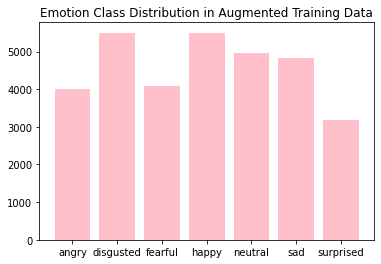

In [20]:
#load data from gdrive
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

#randomly undersample majority class 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class  using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize resampled class distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Emotion Class Distribution in Augmented Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

#resize to make sure input is the correct shape
x_train = np.resize(x_train, (len(x_train), 48,48,3))
x_val = np.resize(x_val, (len(x_val), 48,48,3))
x_test = np.resize(x_test, (len(x_test), 48,48,3))

print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)

## Prepare Model 

In [24]:
vgg = VGG16(weights = 'imagenet', include_top=False, input_shape= (48,48,3))
n_freeze = 19
for layer in vgg.layers[:n_freeze]:
  layer.trainable=False

for (i,layer) in enumerate(vgg.layers):
  print(str(i)+' '+ layer.__class__.__name__, layer.trainable)

def fully_connected(base_model, num_classes):
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  return x

num_class = 7
FC_head = fully_connected(vgg, num_class)
model = Model(inputs=vgg.input, outputs = FC_head)
print(model.summary())

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                             

## Model Training 

The good thing is that the model is working in a reasonable manner. The bad thing is that the model is overfitting on the training data. What can we do? 

Training accuracy was about 91% and test/val accuracy was pleatauing at about 42%

Added 30% dropout layers where overfitting decreases but performance still plateaued at about ~40 for validation set

- Added Dropout 
- Used global average pooling: layer helps aggregate feature map information and helps prevent overfitting caused by fully connected layers in the
model
- Tried all three different optimizers 
- Data augmentation --- but Image data generator eta is in 4 hours and more
- Tried using balanced vs imbalanced training data but no change  
- Try using unfrozen layers [but when i do this loss becomes NaN]
- Tried adding batch norm 2% improvement


In [25]:
epochs = 100
bs = 32
rms_lr = 0.001
sgd_lr = 0.01
adam_lr = 0.001
sgd_decay = 0.0001

lrd = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
checkpoint = ModelCheckpoint('face_vgg.h5', monitor = 'val_accuracy', mode ='max', save_best_only = True, verbose=1)
callbacks = [checkpoint, es, lrd]


sgd = SGD(learning_rate=sgd_lr, momentum=0.9, decay=sgd_decay, nesterov=True) 
adam = Adam(learning_rate=adam_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
rms = RMSprop(learning_rate=rms_lr)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=bs, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data= (x_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
1000/1002 [============================>.] - ETA: 0s - loss: 1.6454 - accuracy: 0.3848
Epoch 1: val_accuracy improved from -inf to 0.36843, saving model to face_vgg.h5
1002/1002 [==============================] - 18s 17ms/step - loss: 1.6452 - accuracy: 0.3849 - val_loss: 1.6348 - val_accuracy: 0.3684 - lr: 0.0100
Epoch 2/100
1000/1002 [============================>.] - ETA: 0s - loss: 1.4640 - accuracy: 0.4407
Epoch 2: val_accuracy improved from 0.36843 to 0.37301, saving model to face_vgg.h5
1002/1002 [==============================] - 17s 16ms/step - loss: 1.4643 - accuracy: 0.4406 - val_loss: 1.6019 - val_accuracy: 0.3730 - lr: 0.0100
Epoch 3/100
 999/1002 [============================>.] - ETA: 0s - loss: 1.3861 - accuracy: 0.4728
Epoch 3: val_accuracy improved from 0.37301 to 0.38037, saving model to face_vgg.h5
1002/1002 [==============================] - 17s 17ms/step - loss: 1.3862 - accuracy: 0.4728 - val_loss: 1.5949 - val_accuracy: 0.3804 - lr: 0.0100
Epoch 4/10

In [27]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

68/68 [==============================] - 1s 17ms/step - loss: 2.1396 - accuracy: 0.4689
Restored model, accuracy: 46.89%



Make a long story ---- 
show insight about everything you tried in a strategic manner. //
Reading literature -- talk about SOTA //
give a strong story -- //
this is why it is an extension 
smaller network and why this is valuable 
talk about costs etc...
Two types of engineer -- what is the most amazing vs what is the cheapest engineer //// 
we are looking for arch with small no. of trainable parameters 
easier to train with smaller dataset


## Questions

- Why is validation accuracy greater than training accuracy after adding dropout? 
- Why does my val loss doesn't decrease but val accuracy increases?

## Notes

**Momentum**

momentum: that accelerates gradient descent in the relevant direction and dampens oscillations Momentum speeds up movement along directions of strong improvement (loss decrease) and also helps the network avoid local minima.

**Nesterov momentum**

nesterov momentum is a simple change to normal momentum. Here the gradient term is not computed from the current position
while gradient may point in right direction, momentum may not always, so the intermediate position is found to redirect momentum 

## References 

1. https://dominikschmidt.xyz/nesterov-momentum/
2. https://medium.com/@heba.elshatoury/predicting-emotion-from-facial-expression-88acc43f96f5